# LoC thresholding notebook

This notebook loads a set of Z-tracks taken across an image volume from the lung-on-a-chip project and thresholds positive/negative expression of set markers based on a manual and unbiased assessment of the underlying images:

1. Load z-tracks, segmentation and images.
2. Initiate a Napari viewer with key bindings to annotate positive/negative expressing cells
3. Assess results
4. Quantify based on manually chosen thresholds

In [1]:
import btrack # import tracking software
import napari # image viewer
from skimage import io # image loader and viewer
import os # for filename manipulations
import glob # for more fn operations 
import pandas as pd # module for data org 
import matplotlib.pyplot as plt # module for plotting
import seaborn as sns # module for plotting
import numpy as np # for math operations
import re
from homuncu_loc import dataio
sns.set(font='Nimbus Sans', style = 'white') # my favourite formatting :)
sns.set_palette('PiYG') # my favourite colours :D 

## 1. Load images and labels

In [57]:
search_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/' # search for image or input basename and dir 
image_base_name = '20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447.tif' 
img_base_dir = dataio.find_image_directory(search_dir, image_base_name) # img_base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/images'
image_fn = os.path.join(img_base_dir, image_base_name)
image_id = dataio.ID_extractor(image_fn)
os.path.exists(image_fn)
image = io.imread(image_fn) # load image

In [58]:
# base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses'
sc_base_dir = img_base_dir.replace('images', 'sc_analyses') 
sc_fns = glob.glob(os.path.join(sc_base_dir, f'*_{image_id}*.h5'))
print(sc_fns)

['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat2.h5']


In [59]:
sc_fn = [fn for fn in sc_fns if fn.endswith('iat2.h5')][0]#sc_fns[-1]
# load labels (tracks and segmentation)
with btrack.io.HDF5FileHandler(sc_fn, 
                                   'r', 
                                       obj_type='obj_type_2'#'obj_type_2'
                                   ) as reader:
        # tracks = [t for t in reader.tracks if np.mean(t.properties['area']) > 1000]
        tracks = reader.tracks#[t for t in reader.tracks if len(t) >= 3]
        segmentation = reader.segmentation
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)
recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks)

[INFO][2023/10/20 10:40:19 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat2.h5...
20-Oct-23 10:40:19 - btrack.io.hdf - INFO     - Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat2.h5...
[INFO][2023/10/20 10:40:19 am] Loading tracks/obj_type_2
20-Oct-23 10:40:19 - btrack.io.hdf - INFO     - Loading tracks/obj_type_2
[INFO][2023/10/20 10:40:19 am] Loading LBEP/obj_type_2
20-Oct-23 10:40:19 - btrack.io.hdf - INFO     - Loading LBEP/obj_type_2
[INFO][2023/10/20 10:40:20 am] Loading objects/obj_type_2 (74603, 5

In [60]:
v = napari.Viewer(title = image_id)
v.add_image(image, channel_axis = -1)
v.add_tracks(napari_tracks)
v.add_labels(recolored_segmentation)

<Labels layer 'recolored_segmentation' at 0x7f91ecef5850>

In [61]:
print()

# Playing around with post tracking edits

In [68]:
zo1 = image[:,...,-1]

In [69]:
zo1_max_proj = np.max(zo1, axis=0)

In [71]:
v.add_image(zo1_max_proj)

<Image layer 'zo1_max_proj' at 0x7f922ceeaa30>

## 2. Initiate a napari session with key bindings

## Thresholding instructions

In [258]:
viewer = napari.Viewer()

viewer.add_image(image, channel_axis=-1)
track_layer = viewer.add_tracks(napari_tracks, tail_length=0, visible = False)
labels = viewer.add_labels(segmentation)
labels.contour = 1 # this makes all the masks into outlines but might slow your computer down A LOT (comment out line if so) 
global image_id 
image_id = re.search(r'\d+(?=_z_tracks)', os.path.basename(labels_fn)).group()

@viewer.bind_key('t')
def ch1_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,1][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, f"{image_id}_ch1_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@viewer.bind_key('b')
def ch1_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,1][cell_index]
    with open(os.path.join(output_dir, f"{image_id}_ch1_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")

@viewer.bind_key('y')
def ch2_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,2][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, f"{image_id}_ch2_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@viewer.bind_key('n')
def ch2_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,2][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, f"{image_id}_ch2_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")

@viewer.bind_key('u')
def ch3_extract_positive_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,3][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, f"{image_id}_ch3_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@viewer.bind_key('m')
def ch3_extract_negative_pixel_value(event=None):
    ### extract cell ID under cursor
    cell_ID = track_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity'][:,3][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, f"{image_id}_ch3_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: invalid value encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in 

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:312: RuntimeWarning: divide by zero encountered i

## Load results of unbiased thresholding

Loading many single-cell measurements of positive and negative cells to decide where the threshold between them is (simply by plotting and deciding at the moment).

In [224]:
print(glob.glob(os.path.join(sc_base_dir, f'{image_id}_ch{channel}*.csv')))

['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/286_ch1_positive_details.csv', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/286_ch1_negative_details.csv']


In [225]:
df = dict()
channels = [1, 2] #1 , 2
for channel in channels:
    for fn in glob.glob(os.path.join(sc_base_dir, f'{image_id}_ch{channel}*.csv')):
        if 'positive' in fn:
            positive_df = pd.read_csv(fn, names=["cell ID", "z slice", "Positive Mean Pixel Intensity"]).replace(r'\(|\)', '', regex=True)
            positive_df.apply(pd.to_numeric, errors='coerce')
        if 'negative' in fn:
            negative_df = pd.read_csv(fn, names=["cell ID", "z slice", "Negative Mean Pixel Intensity"]).replace(r'\(|\)', '', regex=True)
            negative_df.apply(pd.to_numeric, errors='coerce')
    df[channel] = pd.concat((negative_df, positive_df), axis = 1).drop(columns = ['cell ID', 'z slice']).apply(pd.to_numeric, errors='coerce')

In [273]:
channel = 1

Text(0.5, 1.0, 'Positive/negative pixel distribution across channel 1')

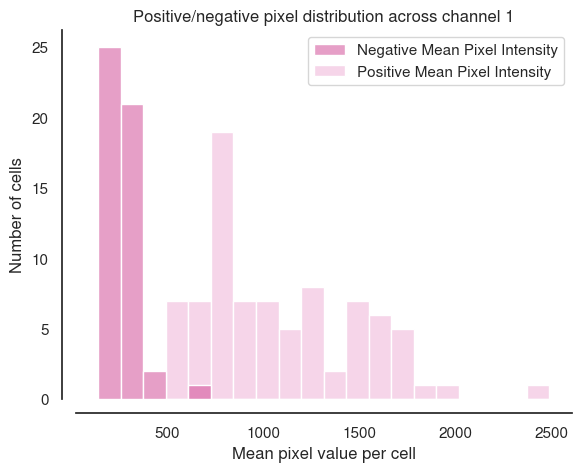

In [227]:
sns.histplot(data = df[channel], bins = 20)
sns.despine(offset = 10)
plt.xlabel('Mean pixel value per cell')
plt.ylabel('Number of cells')
plt.title(f'Positive/negative pixel distribution across channel {channel}')

## Decide threshold label and replot

In [274]:
threshold = 450

Text(0.5, 1.0, 'Positive/negative pixel distribution across channel 1')

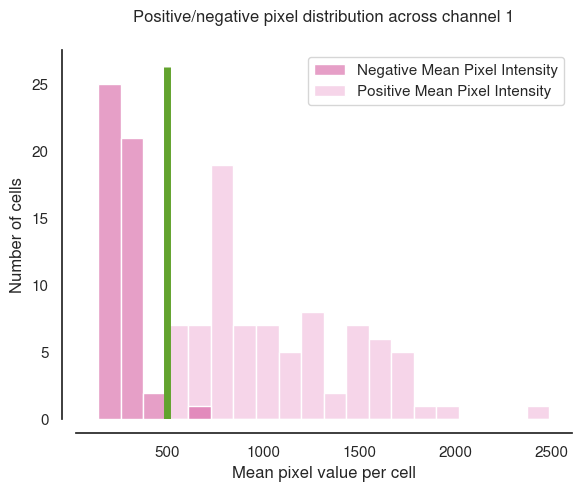

In [229]:
# channel = 1
ax = sns.histplot(data=df[channel], bins=20)
sns.despine(offset=10)
plt.vlines(x=threshold,
           ymax=ax.get_ylim()[-1],
           ymin=ax.get_ylim()[0],
           color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
           linewidth=5)
# plt.text(x=threshold, y=ax.get_ylim()[-1], s='Threshold')
plt.xlabel('Mean pixel value per cell')
plt.ylabel('Number of cells')
plt.title(f'Positive/negative pixel distribution across channel {channel}', pad =20)
# plt.legend(['Threshold'], loc='lower right')

## Quantify

Quantification of number of different cell types according to manually set thresholds

#### Print number of positive and negative cells

In [275]:
# channel = 1
n_positive = len([t for t in tracks if np.max(t.properties['mean_intensity'][:,channel]) >= threshold])
n_negative = len([t for t in tracks if np.max(t.properties['mean_intensity'][:,channel]) < threshold])
print(f'Number of channel {channel} positive cells: {n_positive}')
print(f'Number of channel {channel} negative cells: {n_negative}')
percentage = n_positive / (n_positive+n_negative) *100
print(f'Percentage of positive cells: {percentage:.2f}%')

Number of channel 1 positive cells: 4516
Number of channel 1 negative cells: 731
Percentage of positive cells: 86.07%


#### Plot the number of cells either side of the threshold

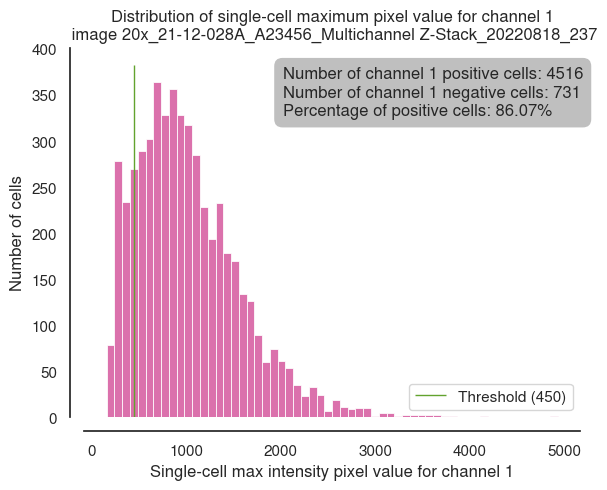

In [276]:
sc_intensities = [np.max(t.properties['mean_intensity'][:,channel]) for t in tracks]
ax = sns.histplot(sc_intensities)
plt.vlines(x=threshold,
           ymax=ax.get_ylim()[-1],
           ymin=ax.get_ylim()[0],
           color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
           linewidth=1)
sns.despine(offset = 10)
plt.xlabel(f'Single-cell max intensity pixel value for channel {channel}')
plt.ylabel('Number of cells')
plt.legend([f'Threshold ({threshold})'], loc='lower right')
ax.text(0.4, 0.95, 
        f'Number of channel {channel} positive cells: {n_positive}\nNumber of channel {channel} negative cells: {n_negative}\nPercentage of positive cells: {percentage:.2f}%',
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='grey', edgecolor='none', alpha=0.5))

image_name = os.path.basename(image_fn).replace('.tif','')
plt.title(f'Distribution of single-cell maximum pixel value for channel {channel}\n image {image_name}')
output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_threshold_quantification.png')
plt.savefig(output_fn, bbox_inches = 'tight', dpi = 314)

# Save out as df/excel

In [ ]:
### define parameters to plot in table
cols = ['Cell ID', f'Max. int. {channels(0).name}', f'Max. int. {channels(1).name}', f'Max. int. {channels(2).name}', f'Max. int. {channels(3).name}', 'Average X', 'Average Y']
### extract some intial measurements
df = pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in tracks], columns= cols)